In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm

In [3]:
import preprocessing as preproc
# help(preproc)

In [4]:
int_freq = 30

# Data Collection

In [6]:
start_date = '2009-01-01'
end_date = '2024-12-31'
date_range = preproc.create_date_range(start_date, end_date)

### Downstream Data (Inflow)

In [8]:
inflow_site = '14128600'

## Collect Dataset #1
df1 = preproc.preprocess(inflow_site, int_freq, start_date, end_date)

COLUMBIA RIVER AT STEVENSON, WA
Removed 24 duplicate rows

Removed 0 rows with NaN in '00065'

Imputed 201 rows


### Upstream Data (Outflow)

In [10]:
outflow_site = '14105700'

## Collect Dataset #2
df2 = preproc.preprocess(outflow_site, int_freq, start_date, end_date)

COLUMBIA RIVER AT THE DALLES, OR
Removed 32 duplicate rows

Removed 437 rows with NaN in '00065'

Imputed 887 rows


### Downstream Data (Forebay Inflow)

In [159]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data/bonneville/"
bon_hourly = pd.read_csv(bon_path + "bon-hourlyops.csv")
bon_hourly['Date Time'] = pd.to_datetime(bon_hourly['Date Time'])
bon_hourly['Date Time'] = bon_hourly['Date Time'] + pd.Timedelta(hours=3)
bon_hourly = bon_hourly.iloc[1:].reset_index(drop=True)

bon = bon_hourly.copy()
bon = bon.rename(columns={"BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]": 'inflow_kcfs'})
bon = bon.rename(columns={'BON.Elev-Forebay.Inst.1Hour.0.CBT-REV [ft]': 'forebay_ft'})
bon = bon.rename(columns={"Date Time": 'datetime'})
bon = bon[['datetime', 'forebay_ft']]

In [161]:
bon.head()

datetime  forebay_ft
0 2022-01-01 00:00:00        74.1
1 2022-01-01 01:00:00        74.2
2 2022-01-01 02:00:00        74.3
3 2022-01-01 03:00:00        74.3
4 2022-01-01 04:00:00        74.3

In [163]:
len(bon)

26303

### Data Export

In [12]:
df_merge = df1.copy()
df_merge.rename(columns={'00065': 'down_inflow'}, inplace=True)
df_merge = df_merge.merge(df2, left_index=True, right_index=True, how='inner')
df_merge.rename(columns={'00065': 'up_outflow'}, inplace=True)
df_merge.drop(['site_no_x', 'site_no_y'], axis=1, inplace=True)
df_merge = df_merge.reset_index()

In [13]:
df_merge.head()

datetime  down_inflow  up_outflow
0 2009-01-01 00:00:00        76.11       76.61
1 2009-01-01 00:30:00        76.19       76.56
2 2009-01-01 01:00:00        76.19       76.47
3 2009-01-01 01:30:00        76.25       76.27
4 2009-01-01 02:00:00        76.20       76.39

In [14]:
df_merge.to_csv('/Users/elizacohn/Desktop/cascaded-hydro/simulation-data/flowdata.csv')

In [165]:
len(df_merge)

280512

### Data Export II

In [193]:
df_merge = bon.copy()
df_merge.rename(columns={'forebay_ft': 'down_inflow'}, inplace=True)
df_merge = df_merge.merge(df2, on='datetime', how='inner')
df_merge.rename(columns={'00065': 'up_outflow'}, inplace=True)
df_merge.drop(['site_no'], axis=1, inplace=True)
df_merge.set_index('datetime', inplace=True)

In [195]:
df_merge.head()

down_inflow  up_outflow
datetime                                    
2022-01-01 00:00:00         74.1       76.48
2022-01-01 01:00:00         74.2       76.35
2022-01-01 02:00:00         74.3       76.39
2022-01-01 03:00:00         74.3       76.35
2022-01-01 04:00:00         74.3       76.14

# Training & Test Set

In [173]:
train_start_year = '2022' # '2008'
test_start_year = '2024'

In [199]:
## Merge downstream and upstream data

# df_range = preproc.dataset_merge(df1, df2, train_start_year, "full")
df_range = preproc.dataset_merge_forebay(df_merge, train_start_year)

In [201]:
df_range.head()

y      x  DoY   day_sin   day_cos    y_norm    x_norm
datetime                                                                     
2022-01-01 00:00:00  74.1  76.48    1  0.017213  0.999852 -0.168652  0.198602
2022-01-01 01:00:00  74.2  76.35    1  0.017213  0.999852 -0.059453  0.117276
2022-01-01 02:00:00  74.3  76.39    1  0.017213  0.999852  0.049745  0.142299
2022-01-01 03:00:00  74.3  76.35    1  0.017213  0.999852  0.049745  0.117276
2022-01-01 04:00:00  74.3  76.14    1  0.017213  0.999852  0.049745 -0.014097

In [203]:
## Create lag features

p = 7 
up_feat = True
down_feat = True 

df_reg, feature_cols = preproc.create_lag_features(df_range, p, up_feat, down_feat)

In [205]:
## Split the data into training and testing sets

train_data = df_reg[(df_reg.index < test_start_year)]
test_data = df_reg[(df_reg.index >= test_start_year)]

X_train = train_data[feature_cols]
y_train = train_data['y_norm']

X_test = test_data[feature_cols]
y_test = test_data['y_norm']

# M0: Previous Term Forecaster

In [208]:
## Simulate Model Forecasting
# Model Output (y_hat): y[t-1]
# Ground Truth (y): y[t]

fitted_vals0 = y_train[:-1].values
y_train0 = y_train[1:].values

## Residuals

In [211]:
## Residuals = y[t] - y[t-1]

residuals0 = y_train0 - fitted_vals0

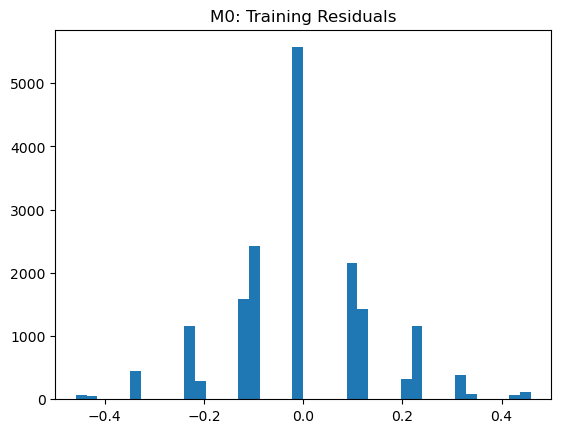

In [213]:
plt.hist(residuals0, bins = 100)
plt.title('M0: Training Residuals')
plt.xlim([-.5, .5])
plt.show()

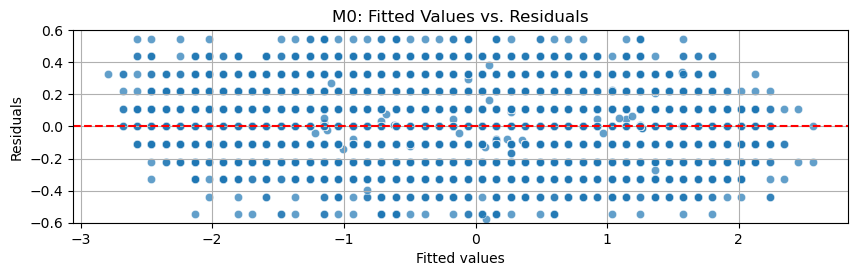

In [215]:
preproc.plot_variance("M0", fitted_vals0, residuals0)

## Evaluation

In [218]:
y_pred0 = y_test[:-1] # Exclude the last element
y_test0 = y_test[1:]  # Exclude the first element

In [220]:
preproc.print_test_stats(y_test0, y_pred0)

RMSE: 0.164
MAE: 0.117
R²: 0.975


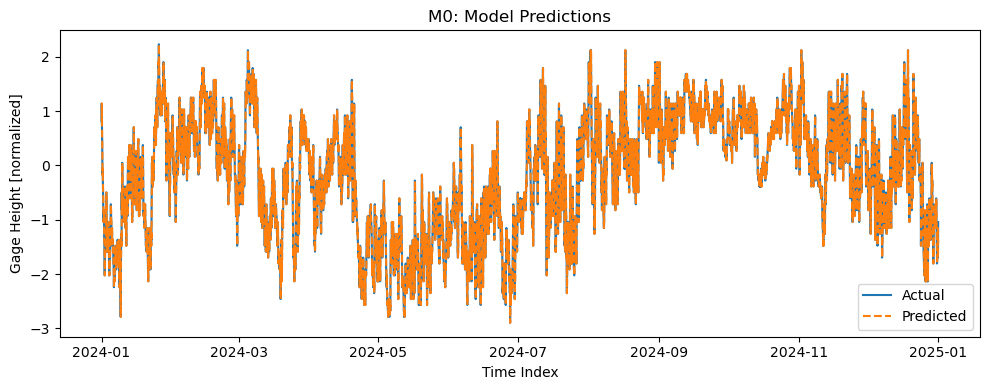

In [222]:
preproc.plot_forecasts("M0", y_test0, y_pred0)

# M1: Linear Regression

In [225]:
# Step 1: Add constant (intercept)
X_train_const = sm.add_constant(X_train)

# Step 2: Fit OLS model
model = sm.OLS(y_train, X_train_const).fit(cov_type='HC1') # Heteroskedasticity-consistent

# Step 3: View summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_norm   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 5.725e+04
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:09:53   Log-Likelihood:                 10251.
No. Observations:               17506   AIC:                        -2.047e+04
Df Residuals:                   17490   BIC:                        -2.035e+04
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.552      0.5

In [227]:
# Extract coefficients and p-values into a tidy DataFrame
coef_df = pd.DataFrame({
    'feature': model.params.index,
    'coefficient': model.params.values
    #'p_value': model.pvalues.values,
    #'t_value': model.tvalues.values
})

# Optional: sort by absolute coefficient size
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

    feature  coefficient
10  Y_Lag_1     1.056777
6   X_Lag_3     0.432566
9   X_Lag_6    -0.424937
7   X_Lag_4     0.387403
4   X_Lag_1    -0.249980
8   X_Lag_5    -0.161588
3    x_norm     0.139630
14  Y_Lag_5    -0.138590
5   X_Lag_2    -0.119221
15  Y_Lag_6     0.108272
11  Y_Lag_2    -0.016054
13  Y_Lag_4    -0.013933
12  Y_Lag_3    -0.010802
1   day_sin    -0.009906
2   day_cos     0.000639
0     const     0.000559


## Residuals

In [230]:
residuals1 = model.resid
fitted_vals1 = model.fittedvalues

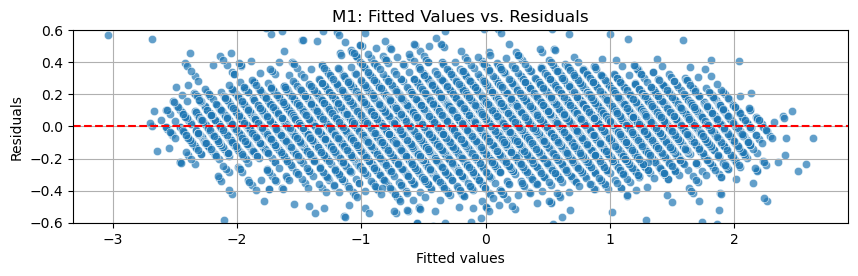

In [232]:
# Checking for Heteroskedasticity

preproc.plot_variance("M1", fitted_vals1, residuals1)

## Evaluation

In [235]:
X_test_const = sm.add_constant(X_test)  # Add intercept term
X_test_const['const'] = np.ones(len(X_test))
X_test_const = pd.DataFrame(X_test_const, columns=model.model.exog_names)
y_pred1 = model.predict(X_test_const)

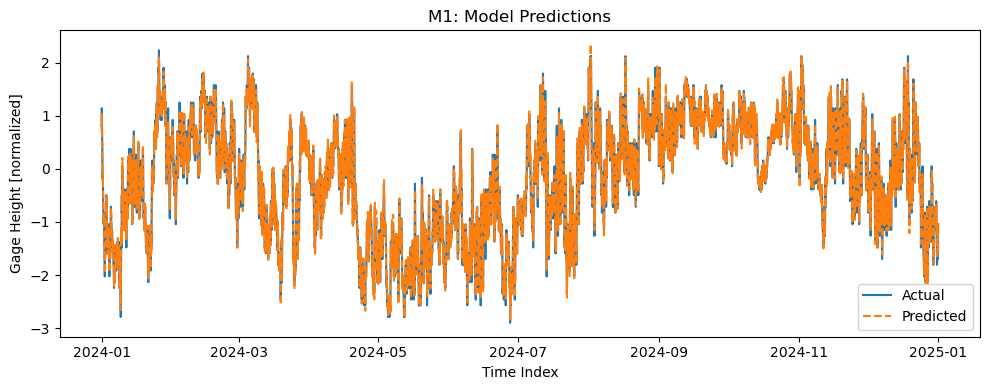

In [237]:
preproc.plot_forecasts("M1", y_test, y_pred1)

In [239]:
preproc.print_test_stats(y_test, y_pred1)

RMSE: 0.132
MAE: 0.098
R²: 0.984


# M2: LASSO

In [41]:
spline_feat = False

if spline_feat:
    lasso_train = X_train_M3_full.copy()
    lasso_test = X_test_M3_full.copy()
else:
    lasso_train = X_train.copy() 
    lasso_test = X_test.copy()

In [42]:
## Cross-Validation for Hyperparameter Finetuning

lasso_cv = LassoCV(cv=5, positive=True).fit(lasso_train, y_train)
alpha_star = lasso_cv.alpha_
print("Best alpha:", alpha_star)

Best alpha: 0.0010135855791023928


In [43]:
## Create and fit LASSO model

#lasso = Lasso(alpha=0, positive=True)  # alpha is the regularization strength (higher = more shrinkage)
lasso = Lasso(alpha=alpha_star, positive=True)
lasso.fit(lasso_train, y_train)

Lasso(alpha=0.0010135855791023928, positive=True)

In [44]:
## Make predictions

y_pred2 = pd.Series(lasso.predict(lasso_test))

In [45]:
## View coefficients

coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lasso.coef_
})

# Optional: Sort by magnitude or filter out zeros
coef_df = coef_df[coef_df['coefficient'] != 0]  # remove zeroed-out features
coef_df = coef_df.sort_values(by='coefficient', key=abs, ascending=False)

print(coef_df)

   feature  coefficient
9  Y_Lag_1     0.986605
2   x_norm     0.013047
1  day_cos     0.000002


## Residuals

In [47]:
fitted_vals2 = lasso.predict(lasso_train)

In [48]:
residuals2 = y_train - fitted_vals2

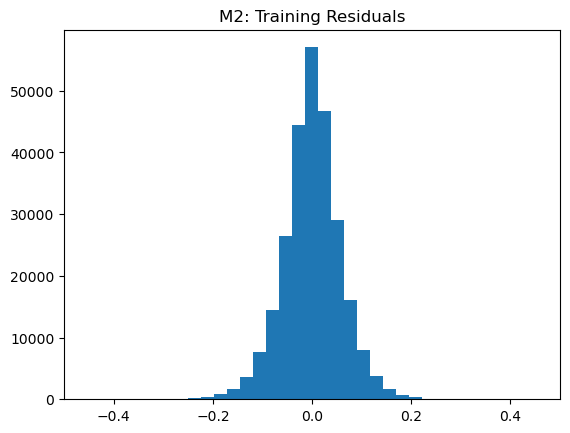

In [49]:
plt.hist(residuals2, bins = 100)
plt.title('M2: Training Residuals')
plt.xlim([-.5, .5])
plt.show()

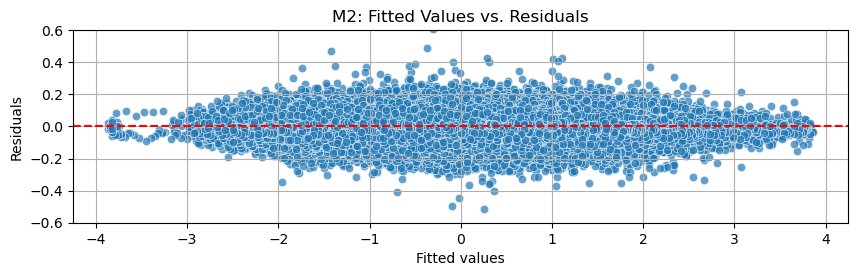

In [50]:
# Checking for Heteroskedasticity

preproc.plot_variance("M2", fitted_vals2, residuals2)

## Evaluation

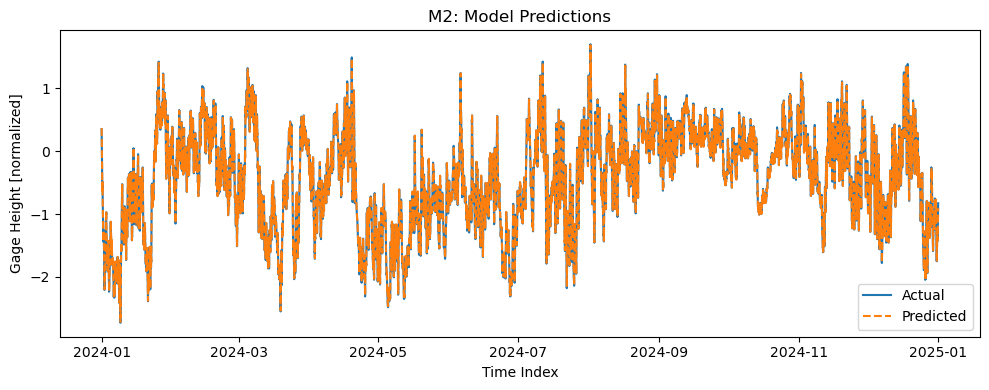

In [52]:
preproc.plot_forecasts("M2", y_test, y_pred2)

In [53]:
preproc.print_test_stats(y_test, y_pred2)

RMSE: 0.058
MAE: 0.044
R²: 0.994


# M3: Spline

In [55]:
from patsy import dmatrix

In [56]:
## Create numerical & continuous time variable

X_train_M3 = X_train_const.copy()
X_train_M3["t"] = (X_train_M3.index - X_train_M3.index[0]).total_seconds() / (3600 * 24)

In [57]:
## Generate spline

# Natural cubic spline with 4 degrees of freedom (adjust as needed)
spline = dmatrix("bs(t, df=4, include_intercept=False)", data=X_train_M3, return_type='dataframe')

In [58]:
## Combine spline basis with lag features

X_train_M3_full = pd.concat([X_train_M3.drop(columns="t"), spline], axis=1)

In [59]:
## Fit the model 

model3 = sm.OLS(y_train, X_train_M3_full).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_norm   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 9.768e+06
Date:                Wed, 02 Jul 2025   Prob (F-statistic):               0.00
Time:                        10:50:17   Log-Likelihood:             4.9420e+05
No. Observations:              262938   AIC:                        -9.884e+05
Df Residuals:                  262917   BIC:                        -9.881e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

## Residuals

In [61]:
residuals3 = model3.resid
fitted_vals3 = model3.fittedvalues

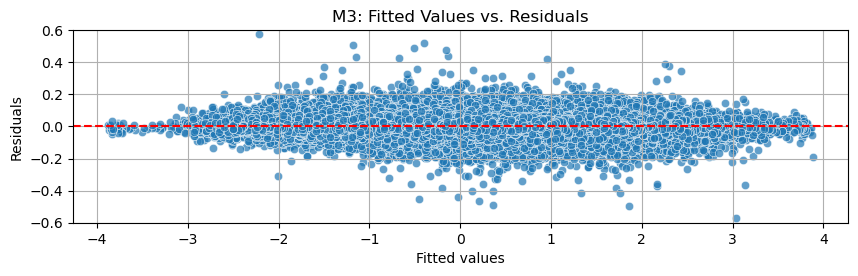

In [62]:
preproc.plot_variance("M3", fitted_vals3, residuals3)

## Evaluation

In [64]:
## Prepare test dataset

X_test_M3 = X_test_const.copy()
X_test_M3["t"] = (X_test.index - X_train.index[0]).total_seconds() / (3600 * 24)

spline_test = dmatrix("bs(t, df=4, include_intercept=False)", data=X_test_M3, return_type='dataframe')
X_test_M3_full = pd.concat([X_test_M3.drop(columns="t"), spline_test], axis=1)

In [65]:
y_pred3 = model3.predict(X_test_M3_full)

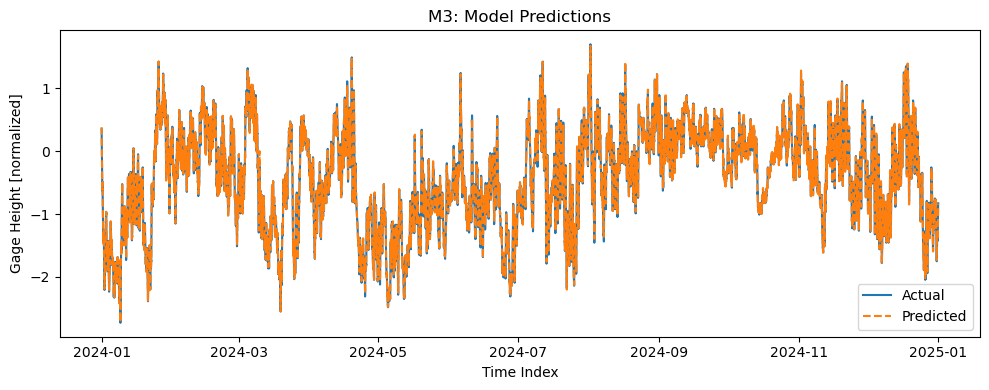

In [66]:
preproc.plot_forecasts("M3", y_test, y_pred3)

In [67]:
preproc.print_test_stats(y_test, y_pred3)

RMSE: 0.032
MAE: 0.023
R²: 0.998


# M4: Prophet

In [69]:
prophet_df = y_train.to_frame(name='y')
prophet_df = prophet_df.reset_index()  
prophet_df.columns = ['ds', 'y']    

In [70]:
from prophet import Prophet

m = Prophet()
m.fit(prophet_df)

10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:49 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
future = y_test.index.to_frame(name='ds')
future = future.reset_index()  
future = future.drop('datetime', axis = 1)

In [72]:
full_future = pd.concat([prophet_df['ds'], future])

In [73]:
forecast = m.predict(full_future)

# forecast.columns

In [74]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
280501 2024-12-31 21:30:00  0.039133   -1.793943    2.051985
280502 2024-12-31 22:00:00  0.059297   -1.798487    1.996287
280503 2024-12-31 22:30:00  0.069331   -1.734788    2.006368
280504 2024-12-31 23:00:00  0.068322   -1.749941    2.177509
280505 2024-12-31 23:30:00  0.056477   -1.791122    2.052186

## Residuals

In [76]:
# Merge actuals and predictions
prophet_merged = prophet_df[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds')
prophet_merged['residual'] = prophet_merged['y'] - prophet_merged['yhat']

In [77]:
prophet_merged.head()

ds         y      yhat  residual
0 2009-01-01 03:00:00  0.750925 -0.224681  0.975606
1 2009-01-01 03:30:00  0.665295 -0.267428  0.932723
2 2009-01-01 04:00:00  0.665295 -0.308866  0.974161
3 2009-01-01 04:30:00  0.665295 -0.347836  1.013131
4 2009-01-01 05:00:00  0.655780 -0.382824  1.038605

In [78]:
prophet_merged_train = prophet_merged.iloc[:len(y_train)]

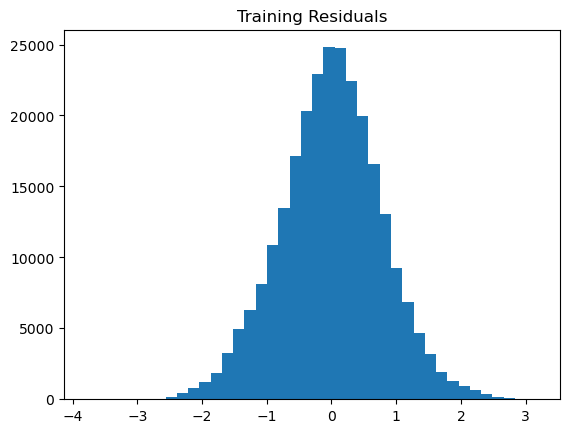

In [79]:
plt.hist(prophet_merged_train.residual, bins = 40)
plt.title('Training Residuals')
plt.show()

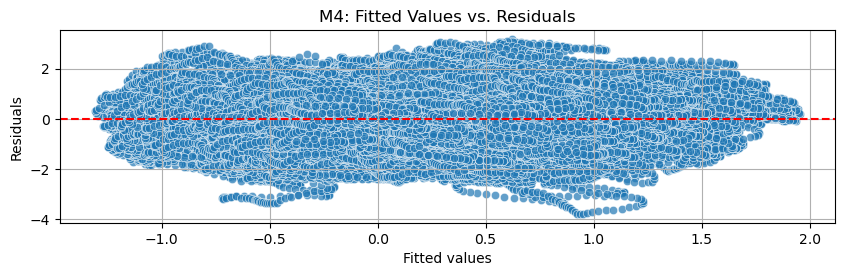

In [80]:
# Checking for Heteroskedasticity

preproc.plot_variance("M4", prophet_merged_train.yhat, prophet_merged_train.residual, bounds=False)

## Evaluation

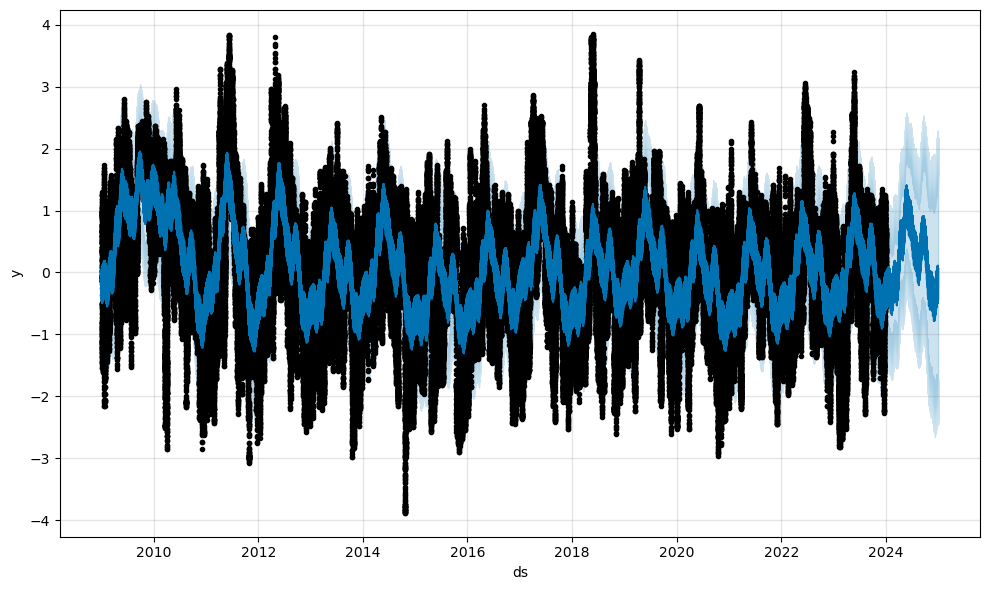

In [82]:
fig1 = m.plot(forecast)

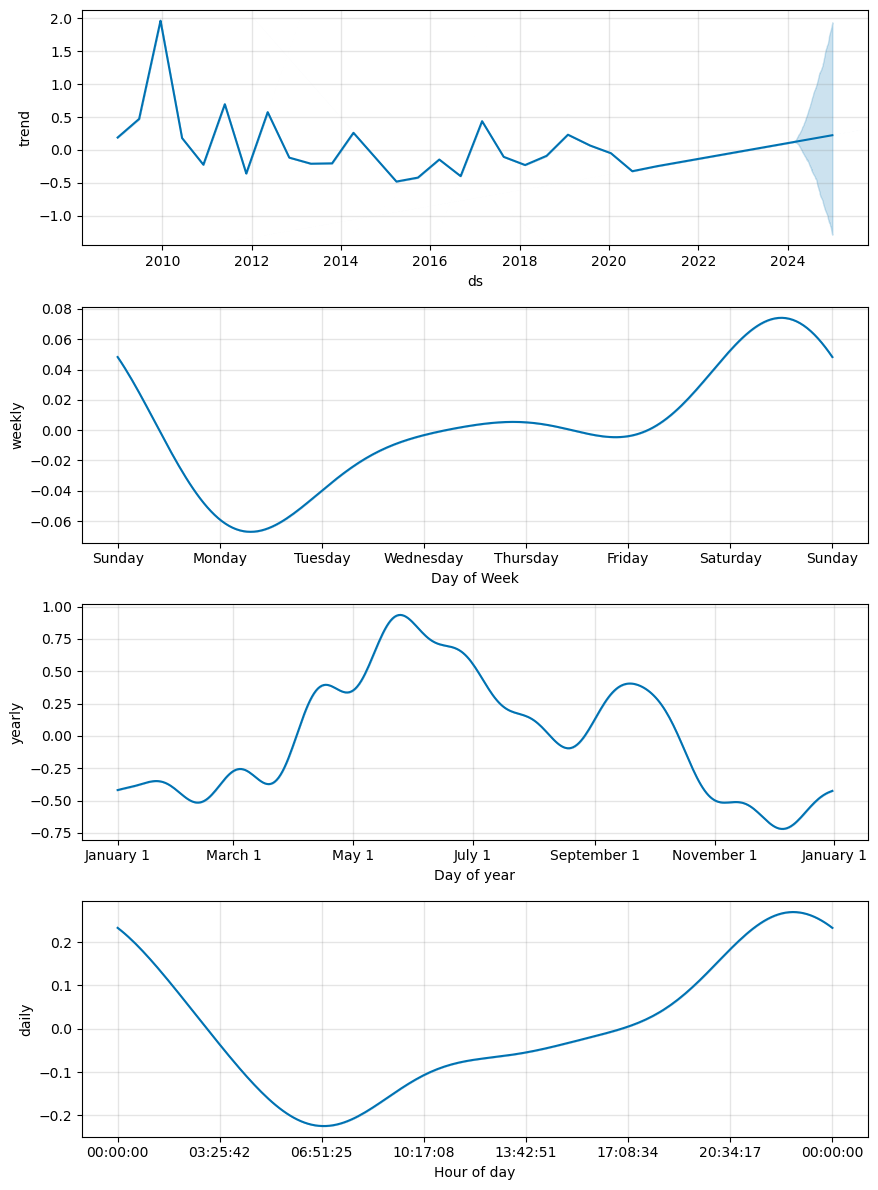

In [83]:
fig2 = m.plot_components(forecast)


In [84]:
y_pred4 = forecast.yhat[-len(y_test):]

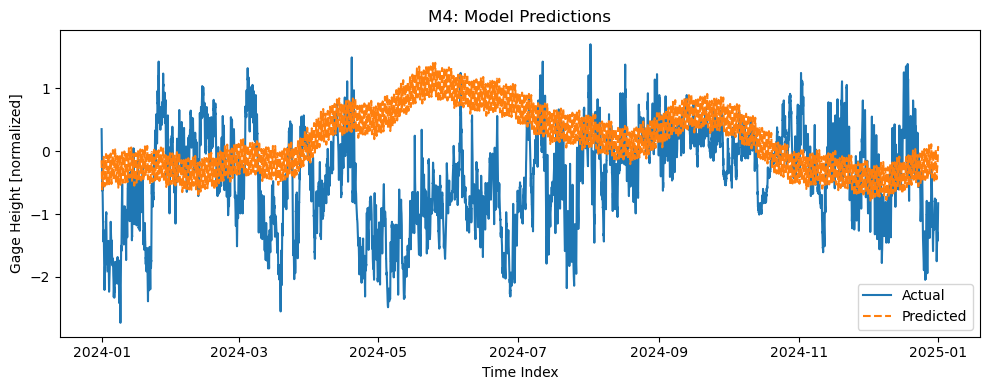

In [85]:
preproc.plot_forecasts("M4", y_test, y_pred4)

In [86]:
preproc.print_test_stats(y_test, y_pred4)

RMSE: 1.108
MAE: 0.854
R²: -1.145
